In [68]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import numpy as np
from tensorflow.keras.layers import Conv2D,UpSampling2D,ReLU,MaxPool2D,Input,concatenate
import os
import numpy as np
import pydot
import graphviz
import pydotplus
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tqdm import tqdm
import skimage
from skimage.transform import resize
from skimage.io import imread

2.2.0
Num GPUs Available:  1


In [ ]:
!sudo apt install subversion 
!svn checkout https://github.com/dixitaniket/datasets_projects/trunk/data-science-bowl-2018

In [3]:
##loading the data

In [4]:
train_data="./data-science-bowl-2018/stage1_train/"

#
data_train_=[]
data_labels_=[]
# loading the images of the neuclie
for i in tqdm(os.listdir(train_data)):
    for k in os.listdir(os.path.join(train_data,i+"/images/")):
        data_train_.append(resize(imread(os.path.join(os.path.join(train_data,i+"/images/"),k),as_gray=True),output_shape=(256,256,1)))
    holder=np.zeros(data_train_[0].shape)
    for k in os.listdir(os.path.join(train_data,i+"/masks/")):
        holder=np.add(holder,resize(imread(os.path.join(os.path.join(train_data,i+"/masks/"),k),as_gray=True),output_shape=(256,256,1)))
    data_labels_.append(holder)
len(data_labels_)
len(data_train_)


100%|██████████| 670/670 [06:29<00:00,  1.72it/s]


670

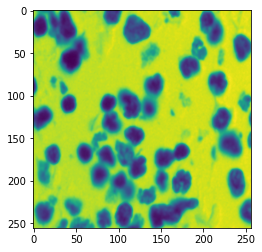

In [10]:
# visualising the dataset
plt.imshow(np.resize(data_train_[0],(256,256)))

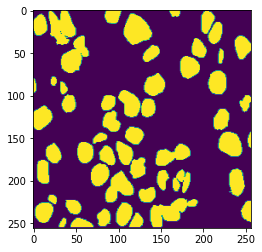

In [11]:
# visulating the masks for the image
plt.imshow(np.resize(data_labels_[0],(256,256)))

In [12]:
data_train_=np.array(data_train_)
data_labels_=np.array(data_labels_)

In [13]:
data_train_.shape

(670, 256, 256, 1)

In [14]:
data_labels_.shape

(670, 256, 256, 1)

In [64]:
# the unet model
def model_architecture(input_shape):
    input_layer=Input(input_shape)
    conv1=Conv2D(64,(3,3),activation="relu",padding="same")(input_layer)
    conv1=Conv2D(64,(3,3),activation="relu",padding="same")(conv1)

    conv2=MaxPool2D(strides=(2,2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation="relu",padding="same")(conv2)
    conv2 = Conv2D(128, (3, 3), activation="relu",padding="same")(conv2)

    conv3=MaxPool2D(strides=(2,2))(conv2)
    conv3=Conv2D(256,(3,3),activation="relu",padding="same")(conv3)
    conv3=Conv2D(256,(3,3),activation="relu",padding="same")(conv3)

    conv4 = MaxPool2D(strides=(2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), activation="relu",padding="same")(conv4)
    conv4 = Conv2D(512, (3, 3), activation="relu",padding="same")(conv4)
    print(conv4.shape)
    conv5 = MaxPool2D(strides=(2, 2))(conv4)
    conv5 = Conv2D(1024, (3, 3), activation="relu",padding="same")(conv5)
    conv5 = Conv2D(1024, (3, 3), activation="relu",padding="same")(conv5)


    layers=UpSampling2D((2,2))(conv5)
    layers=Conv2D(512,(1,1),activation="relu",padding="same")(layers)
    concatenate1 = concatenate([conv4,layers], axis=3)
    layers = Conv2D(512, (3, 3), activation="relu",padding="same")(concatenate1)
    conv6 = Conv2D(512, (3, 3), activation="relu",padding="same")(layers)
    print(conv6.shape)

    layers=UpSampling2D((2,2))(conv6)
    layers=Conv2D(256,(1,1),activation="relu",padding="same")(layers)
    concatenate2=concatenate([conv3,layers],axis=3)
    layers = Conv2D(256, (3, 3), activation="relu",padding="same")(concatenate2)
    conv7 = Conv2D(256, (3, 3), activation="relu",padding="same")(layers)
    # print(layers.shape)

    layers=UpSampling2D((2,2))(conv7)
    layers = Conv2D(128, (1, 1), activation="relu",padding="same")(layers)
    concatenate3=concatenate([conv2,layers],axis=3)
    layers = Conv2D(128, (3, 3), activation="relu",padding="same")(concatenate3)
    layers = Conv2D(128, (3, 3), activation="relu",padding="same")(layers)
    # print(layers.shape)

    layers=UpSampling2D((2,2))(layers)
    layers = Conv2D(64, (1, 1), activation="relu",padding="same")(layers)
    concatenate4=concatenate([conv1,layers],axis=3)
    layers = Conv2D(64, (3, 3), activation="relu",padding="same")(concatenate4)
    layers = Conv2D(64, (3, 3), activation="relu",padding="same")(layers)
    # print(layers.shape)
    layers=Conv2D(2,(3,3),activation="relu",padding='same')(layers)
    output_layer = Conv2D(1, (1, 1), activation="sigmoid",padding="same")(layers)
    # print(layers.shape)

    model=Model(input_layer,output_layer)
    model.compile(optimizer='sgd',loss="binary_crossentropy",metrics="accuracy")
    return model


In [65]:
model=model_architecture(data_train_.shape[1:])

(None, 32, 32, 512)
(None, 32, 32, 512)


In [112]:
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 256, 256, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_48[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_49[0][0]                  
____________________________________________________________________________________________

In [ ]:
# plotting the model for better understanding
plot_model(model,"model_architecture.png",show_shapes=True)

In [103]:
# defining callbacks and chekpoints
filepath="checkpoints"
check_points=tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    epochs=5
)

In [104]:
# eaRLY stopping
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=3

)

In [105]:
# tensorboard callbacks
tens_board=tf.keras.callbacks.TensorBoard(
    log_dir="logs",
    update_freq=5,
)

In [107]:
seed=10
dicts=dict(rotation_range=0.2,
           rescale=1./255,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

train_image_gen=ImageDataGenerator(**dicts)
train_image_datagen=train_image_gen.flow(data_train_,seed=seed,batch_size=2)

mask_image_gen=ImageDataGenerator(**dicts)
mask_image_datagen=mask_image_gen.flow(data_labels_,seed=seed,batch_size=2)
# datagens here
final_gen=zip(train_image_datagen,mask_image_datagen)


In [ ]:
model.fit(data_train_,data_labels_,epochs=30,callbacks=[check_points,tens_board],batch_size=16)
# model.fit_generator(final_gen,epochs=30,callbacks=[check_points,tens_board])

In [110]:
import imageio

In [81]:
testing=[]
train_data="./data-science-bowl-2018/stage1_test/"
for i in tqdm(os.listdir(train_data)):
    for k in os.listdir(os.path.join(train_data,i+"/images/")):
        testing.append(resize(imread(os.path.join(os.path.join(train_data,i+"/images/"),k),as_gray=True),output_shape=(256,256,1)))

100%|██████████| 65/65 [00:01<00:00, 43.05it/s]


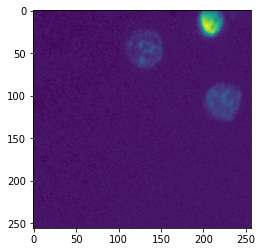

In [92]:
# testing contains the testing data set
plt.imshow(testing[10].reshape(256,256))

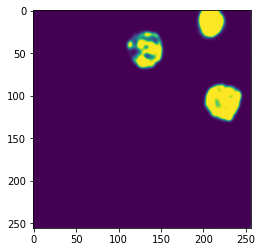

In [101]:
# ans contains the predictions and evaluation of the testing dataset
plt.imshow(ans[10].reshape(256,256))

In [ ]:
# generating gif of the test data
with imageio.get_writer('./images_testing.gif', mode='I',duration=0.5) as writer:
    for filename in testing:
        writer.append_data(filename)

In [ ]:
# generating gif of the test results
with imageio.get_writer('./masking_images_testing.gif', mode='I',duration=0.5) as writer:
    for filename in ans:
        writer.append_data(filename)